In [1]:
import sys
import os
sys.path.append('/usr0/home/drschwar/src/bert_erp/')
sys.path.append('/usr0/home/drschwar/src/subplot_artist')
import json
import dataclasses
from collections import OrderedDict

import numpy as np

from bert_erp_paths import Paths
from bert_erp_datasets import get_indices_from_normalized_coordinates
from run_variations import named_variations, task_hash
from analysis import print_variation_results, sentence_predictions, read_variation_results, print_variation_results_sliced, \
    text_heat_map_html, k_vs_k
from result_output import read_predictions
from occlusion import run_occlusion, read_occlusion_predictions, occlusion_sensitivity
%matplotlib inline
from subplot_artist import SubplotArtist, ColorbarArtist, render_subplot_artists, matshow

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [2]:
# run_occlusion('hp_fmri_20')

In [9]:
import cortex

paths = Paths()
variation = 'hp_fmri_20'
subject = 'I'
training_variations, settings, num_runs, _, aux_loss = named_variations(variation)
occlusion_validation_path_fmt = os.path.join(
    paths.result_path, variation, task_hash(training_variations[0]), 'run_{}', 'output_validation_occlusion.npz')

indices, _, num_data = get_indices_from_normalized_coordinates(subject, x=0.73, y=0.35, z=0.5, distance=3)

mask = np.full(num_data, False)
mask[indices] = True

accuracies = list()
heat_maps = list()
for index_run in range(num_runs):
    occlusion_results = read_occlusion_predictions(occlusion_validation_path_fmt.format(index_run))
    non_occluded_predictions = np.array([r.prediction[0][mask] for r in occlusion_results['hp_fmri_{}'.format(subject)]])
    targets = np.array([r.target[mask] for r in occlusion_results['hp_fmri_{}'.format(subject)]])
    accuracies.append(k_vs_k(non_occluded_predictions, targets))
    sensitivities = occlusion_sensitivity(occlusion_results['hp_fmri_{}'.format(subject)], mask)
    heat_maps.extend([text_heat_map_html(s.tokens, s.sensitivity, cmap='viridis') for s in sensitivities])

accuracies = np.mean(np.concatenate(accuracies, axis=0), axis=0)
print(np.min(accuracies), np.max(accuracies))
volume_data = np.full(mask.shape, np.nan)
volume_data[mask] = accuracies
html = '<div>' + '</div><div>'.join(heat_maps) + '</div>'
volume = cortex.Volume(
    volume_data, 
    'fMRI_story_{}'.format(subject), 
    '{}_ars'.format(subject), 
    mask=cortex.db.get_mask('fMRI_story_{}'.format(subject), '{}_ars'.format(subject), 'thick'), 
    vmin=0., vmax=1., cmap='viridis')

from IPython.core.display import display, HTML
display(HTML(html))

cortex.webshow({subject: volume}, open_browser=False)

Started server on port 57182


/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


<WebApp(Thread-5, started 139842908305152)>

In [10]:
paths = Paths()
variation = 'hp_fmri_meg'
training_variations, settings, num_runs, _, aux_loss = named_variations(variation)
for training_variation in training_variations:
    training_variation = training_variation
    print_variation_results(paths, variation, training_variation, aux_loss, num_runs)

/usr0/home/drschwar/src/bert_erp/analysis.py:134: RuntimeWarning: Mean of empty slice
  result_dict = dict((k, np.nanmean(result_dict[k])) for k in result_dict)
/usr0/home/drschwar/src/bert_erp/analysis.py:134: RuntimeWarning: Mean of empty slice
  result_dict = dict((k, np.nanmean(result_dict[k])) for k in result_dict)
/usr0/home/drschwar/src/bert_erp/analysis.py:134: RuntimeWarning: Mean of empty slice
  result_dict = dict((k, np.nanmean(result_dict[k])) for k in result_dict)
/usr0/home/drschwar/src/bert_erp/analysis.py:134: RuntimeWarning: Mean of empty slice
  result_dict = dict((k, np.nanmean(result_dict[k])) for k in result_dict)
/usr0/home/drschwar/src/bert_erp/analysis.py:209: RuntimeWarning: Mean of empty slice
  value = np.nanmean(aggregated[name].values(metric)) if metric in aggregated[name] else np.nan


Variation (4 of 4 runs found): hp_fmri_I, hp_meg
  name          mse     pove    povu    variance    r_seq  
  hp_meg       1.18    -0.18    1.18        1.01     0.01  
  hp_fmri_I    1.05    -0.04    1.04        1.01      nan  


Variation (4 of 4 runs found): hp_meg
  name       mse     pove    povu    variance    r_seq  
  hp_meg    1.12    -0.11    1.11        1.01     0.01  




/usr0/home/drschwar/src/bert_erp/analysis.py:134: RuntimeWarning: Mean of empty slice
  result_dict = dict((k, np.nanmean(result_dict[k])) for k in result_dict)


Variation (4 of 4 runs found): hp_fmri_I
  name          mse     pove    povu    variance    r_seq  
  hp_fmri_I    1.05    -0.04    1.04        1.01      nan  




/usr0/home/drschwar/src/bert_erp/analysis.py:209: RuntimeWarning: Mean of empty slice
  value = np.nanmean(aggregated[name].values(metric)) if metric in aggregated[name] else np.nan


In [3]:
import cortex

paths = Paths()

def get_mask_for_subject(subject):
    return cortex.db.get_mask('fMRI_story_{}'.format(subject), '{}_ars'.format(subject), 'thick')
    
def make_volume(data, subject, mask=None, **kwargs):
    if mask is None:
        mask = get_mask_for_subject(subject)
    return cortex.Volume(data, 'fMRI_story_{}'.format(subject), '{}_ars'.format(subject), mask=mask, **kwargs)

def variation_paired_data(variation_a, variation_b, values='k_vs_k', k_vs_k_k=20, num_k_vs_k_samples=1000):
    if values != 'k_vs_k':
        num_k_vs_k_samples = 0
    else:
        values = '{0}_vs_{0}'.format(k_vs_k_k)
    training_variations_a, settings_a, num_runs_a, _, aux_loss_a = named_variations(variation_a)
    training_variations_b, settings_b, num_runs_b, _, aux_loss_b = named_variations(variation_b)
    result = OrderedDict()
    for training_variation_a in training_variations_a:
        if training_variation_a in training_variations_b:
            aggregated_a, count_runs = read_variation_results(
                paths, variation_a, training_variation_a, aux_loss_a, num_runs_a, compute_scalar=False, 
                    k_vs_k_k=k_vs_k_k, k_vs_k_num_samples=num_k_vs_k_samples)
            aggregated_b, _ = read_variation_results(
                paths, variation_b, training_variation_a, aux_loss_b, num_runs_b, compute_scalar=False,
                    k_vs_k_k=k_vs_k_k, k_vs_k_num_samples=num_k_vs_k_samples)
            for k in aggregated_a:
                if k.startswith('hp_fmri_') and k in aggregated_b:
                    data_a = np.nanmean(np.array(aggregated_a[k].values(values)), axis=0)
                    data_b = np.nanmean(np.array(aggregated_b[k].values(values)), axis=0)
                if training_variation_a not in result:
                    result[training_variation_a] = OrderedDict()
                result[training_variation_a][k[len('hp_fmri_'):]] = (data_a, data_b)
    return result

def variation_data(variation, a=None, b=None, values='k_vs_k', k_vs_k_k=20, num_k_vs_k_samples=1000):
    if values != 'k_vs_k':
        num_k_vs_k_samples = 0
    else:
        values = '{0}_vs_{0}'.format(k_vs_k_k)
    training_variations, settings, num_runs, _, aux_loss = named_variations(variation)
    result = OrderedDict()
    if a is not None:
        if b is not None:
            aggregated_a, count_runs = read_variation_results(
                paths, variation, a, aux_loss, num_runs, compute_scalar=False, 
                k_vs_k_k=k_vs_k_k, k_vs_k_num_samples=num_k_vs_k_samples)
            aggregated_b, _ = read_variation_results(
                paths, variation, b, aux_loss, num_runs, compute_scalar=False, 
                k_vs_k_k=k_vs_k_k, k_vs_k_num_samples=num_k_vs_k_samples)
            for k in aggregated_a:
                if k.startswith('hp_fmri_') and k in aggregated_b:
                    data_a = np.nanmean(np.array(aggregated_a[k].values(values)), axis=0)
                    data_b = np.nanmean(np.array(aggregated_b[k].values(values)), axis=0)
                    result[k[len('hp_fmri_'):]] = (data_a, data_b)
        else:
            aggregated, count_runs = read_variation_results(
                paths, variation, a, aux_loss, num_runs, compute_scalar=False, k_vs_k_num_samples=1000)
            for k in aggregated:
                if k.startswith('hp_fmri_'):
                    data = np.nanmean(np.array(aggregated[k].values(values)), axis=0)
                result[k[len('hp_fmri_'):]] = data
    else:
        for training_variation in training_variations:
            aggregated, count_runs = read_variation_results(
                paths, variation, training_variation, aux_loss, num_runs, compute_scalar=False, k_vs_k_num_samples=1000)
            
            for k in aggregated:
                if k.startswith('hp_fmri_'):
                    data = np.nanmean(np.array(aggregated[k].values(values)), axis=0)
                if training_variation not in result:
                    result[training_variation] = OrderedDict()
                result[training_variation][k[len('hp_fmri_'):]] = data
    return result

def item_from_dict(d):
    if len(d) != 1:
        raise ValueError('Expected a dictionary with a single item')
    for k in d:
        return d[k]

In [4]:
data = item_from_dict(variation_data('hp_fmri_20'))
for subject in data:
    print('{} min: {}, max: {}'.format(subject, np.nanmin(data[subject]), np.nanmax(data[subject])))
volume_dict = dict(
    ('{}, 20_vs_20, fine-tuned'.format(s), make_volume(data[s], s, vmin=0.5, vmax=1.0, cmap='viridis')) for s in data)
cortex.webshow(volume_dict, open_browser=False)

I min: 0.3125, max: 0.917
Started server on port 34172


/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


<WebApp(Thread-4, started 139768881563392)>

In [4]:
data = item_from_dict(variation_data('hp_fmri_20_linear'))
for subject in data:
    print('{} min: {}, max: {}'.format(subject, np.nanmin(data[subject]), np.nanmax(data[subject])))
volume_dict = dict(
    ('{}, 20_vs_20, linear-only'.format(s), make_volume(data[s], s, vmin=0.5, vmax=1.0, cmap='viridis')) for s in data)
cortex.webshow(volume_dict, open_browser=False)

I min: 0.30574999999999997, max: 0.77725
Started server on port 43435


/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


<WebApp(Thread-5, started 139942756054784)>

In [6]:
data = item_from_dict(variation_paired_data('hp_fmri_20', 'hp_fmri_20_linear'))
for subject in data:
    d = data[subject][0] - data[subject][1]
    data[subject] = np.where(np.logical_and(data[subject][0] < 0.5, data[subject][1] < 0.5), np.nan, d)
    print('{} min: {}, max: {}'.format(subject, np.nanmin(data[subject]), np.nanmax(data[subject])))
volume_dict = dict(
    ('{}, 20_vs_20, fine-tuned - linear-only'.format(s), make_volume(data[s], s, vmin=-0.5, vmax=0.5, cmap='bwr')) for s in data)
cortex.webshow(volume_dict, open_browser=False)

I min: -0.24675000000000008, max: 0.37974999999999987
Started server on port 14810


/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


<WebApp(Thread-7, started 139942248314624)>

In [3]:
volume_dict = make_volume_dict(
    'ns_hp', 
    a=('hp_fmri_I',), 
    b=('ns_lh_pt', 'ns_lh_at', 'ns_lh_ifg', 'ns_lh_ifgpo', 'ns_lh_mfg', 'ns_lh_ag', 'ns_rh_pt', 
       'ns_rh_at', 'ns_rh_ifg', 'ns_rh_ifgpo', 'ns_rh_mfg', 'ns_rh_ag', 'hp_fmri_I'))
cortex.webshow(volume_dict, open_browser=False)

-0.685063 0.14576104
Started server on port 7742


/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


<WebApp(Thread-5, started 139761454266112)>

In [6]:
training_variations, settings, num_runs, _, aux_loss = named_variations('hp_fmri_meg')
aggregated, count_runs = read_variation_results(
    paths, 'hp_fmri_meg', ('hp_fmri_I', 'hp_meg'), aux_loss, num_runs, compute_scalar=False)  

In [7]:
data = np.nanmean(np.array(aggregated['hp_meg'].values('pove')), axis=0)
print(np.nanmin(data), np.nanmax(data))

-19.23587 -0.2127024


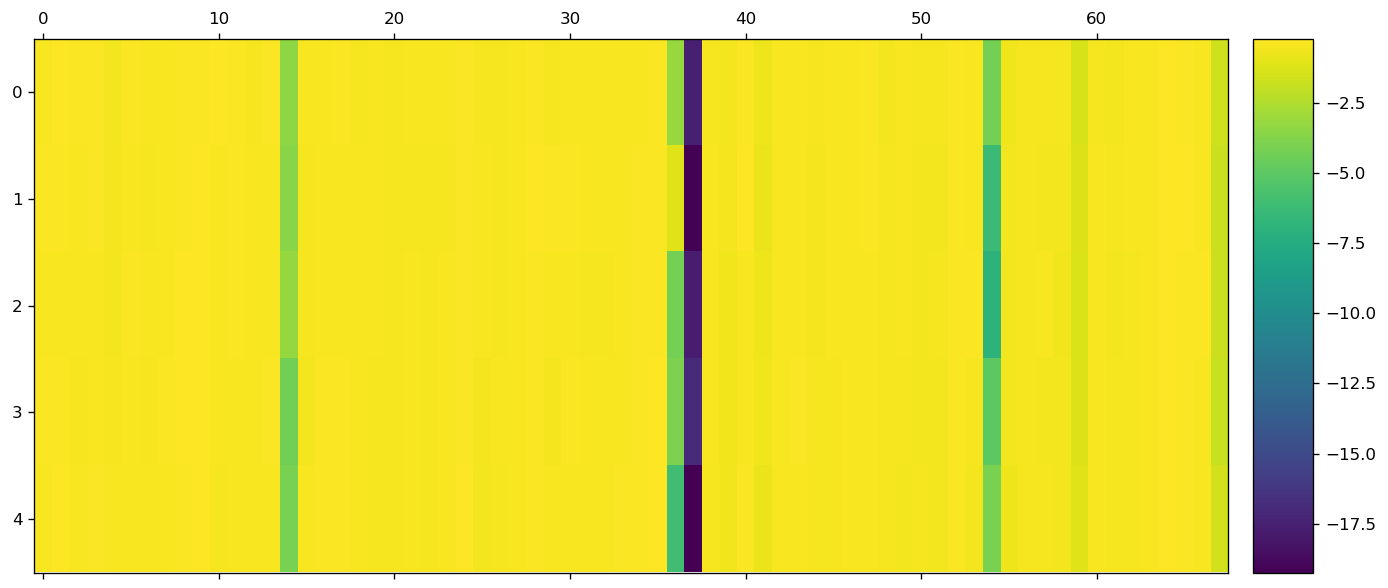

In [8]:
colorbar = ColorbarArtist(width=0.5, height=5)
render_subplot_artists(
    [SubplotArtist(width=10, height=5, render_fn=lambda ax: matshow(ax, data.T), colorbar_artist=colorbar), 
     colorbar], dpi=120, is_tight_layout=True)

In [11]:
import sys
import os
sys.path.append('/path/to/your/bert_erp/')
from bert_erp_paths import Paths
from run_variations import named_variations, task_hash
from bert_erp_modeling import BertMultiPredictionHead
# the paths object maintains all of the paths used everywhere in the system. For example, where the 
# results are stored, where the data sets are, and where the saved models go
paths = Paths()
# in run_variations.py, you can see that one of the script parameters is --name. That name selects a suite of settings
# for training, the most important of which are what data to load, and what to include in the loss function. Here, we
# need the name of interest for loading the models
variation_set_name = 'hp_fmri_20'
# the named variations function returns metadata for the --name parameter that we need to do the loading
# training_variations: a list of tuples. Each tuple represents the terms to use in the loss
# settings: The settings object, which contains a bunch of settings to use for training/eval
# num_runs: How many train/test splits and random intializations for --name
# min_memory: Manual estimate of how much memory this variation needs; may use in future for 
#    automatic GPU selection, but not actively used
# aux_loss: A set of auxiliary loss tasks which are invariant across training variations and data sets, for example 
#    the distance to the syntactic head is available (via spaCy) for all examples
training_variations, settings, num_runs, _, aux_loss = named_variations(variation_set_name)
# the model directory is a combination of the model base path from paths, the variation_set_name, and a hash of the
# loss terms. The auxiliary loss tasks are NOT included in the hash. This is by design.
model_dir = os.path.join(paths.model_path, variation_set_name, task_hash(set(training_variations[0])))
# For each run, we also have a separate directory within the model directory; for i in range(num_runs), 
# you have a subdirectory 'run_{}'.format(i)
model = BertMultiPredictionHead.load(os.path.join(model_dir, 'run_0'))

Loading harry_potter...done


Run:   0%|          | 0/4 [00:00<?, ?it/s]

TypeError: get_tokens() missing 1 required positional argument: 'item_id'

In [17]:

print(results['hp_fmri_I'][0])

OutputResult(name='hp_fmri_I', critic_type='single_mse', critic_kwargs=None, unique_id=264, data_key='harry_potter', tokens=['[CLS]', 'the', 'broom', 'and', '-', '-', 'w', '##ham', '-', '-', 'a', 'thud', 'and', 'a', 'nasty', 'crack', 'and', 'neville', 'lay', 'faced', '##own', 'on', 'the', 'grass', '[SEP]'], mask=array([ True,  True,  True, ...,  True,  True,  True]), prediction=array([-0.09317275,  0.24526322,  0.12415837, ..., -0.3126186 ,
        0.08611324, -0.2087065 ], dtype=float32), target=array([ 0.01550846,  0.04356471,  1.8168777 , ..., -0.00603888,
       -0.01358311,  0.02635652], dtype=float32), sequence_type='single')


In [4]:
sentence_outputs = sentence_predictions(paths, variation, training_variations[1], aux_loss, num_runs)

In [52]:
erps = ('elan', 'lan', 'n400', 'epnp', 'p600', 'pnp')

def mean_prediction(outputs, value_from='prediction'):
    return np.nanmean(np.array([o[value_from] for o in outputs]), axis=0)

def max_erp_values(output_dict, value_from='prediction'):
    return dict((erp, np.nanmax(mean_prediction(output_dict[erp], value_from))) for erp in erps)
    
def max_diff_erp(output_dict, value_from='prediction'):
    result = dict()
    for target_erp in erps:
        target_prediction = mean_prediction(output_dict[target_erp], value_from)
        diff = np.zeros_like(target_prediction)
        for other_erp in erps:
            if other_erp == target_erp:
                continue
            other_prediction = mean_prediction(output_dict[other_erp], value_from)
            diff = diff + target_prediction - other_prediction
        result[target_erp] = np.max(diff)
    return result

def which_word_dist_max(output_dict, value_from='prediction'):
    # value_from is ignored here, just including so we can call score sentences
    result = dict()
    for erp in erps:
        prediction = mean_prediction(output_dict[erp], value_from='prediction')
        target = mean_prediction(output_dict[erp], value_from='target')
        max_prediction = np.argmax(prediction)
        max_target = np.nanargmax(target)
        result[erp] = np.abs(max_prediction - max_target)
    return result
        
def which_word_dist_max_diff(output_dict, value_from='prediction'):
    # value_from is ignored here, just including so we can call score sentences
    result = dict()
    for focus_erp in erps:
        focus_prediction = mean_prediction(output_dict[focus_erp], value_from='prediction')
        focus_target = mean_prediction(output_dict[focus_erp], value_from='target')
        diff_prediction = np.zeros_like(focus_prediction)
        diff_target = np.zeros_like(focus_target)
        for other_erp in erps:
            if other_erp == focus_erp:
                continue
            other_prediction = mean_prediction(output_dict[other_erp], value_from='prediction')
            other_target = mean_prediction(output_dict[other_erp], value_from='target')
            diff_prediction = diff_prediction + focus_prediction - other_prediction
            diff_target = diff_target + focus_target - other_target
        max_prediction = np.argmax(diff_prediction)
        max_target = np.nanargmax(diff_target)
        result[focus_erp] = np.abs(max_prediction - max_target)
    return result

def score_sentences(sentence_outputs, data_key, score_fn, value_from='prediction', strip_id=False, strip_score=False):
    if strip_id and strip_score:
        raise ValueError('That doesn\'t make sense')
    result = dict()
    for unique_id in sentence_outputs[data_key]:
        scores = score_fn(sentence_outputs[data_key][unique_id], value_from)
        for name in scores:
            if name not in result:
                result[name] = list()
            result[name].append((unique_id, scores[name]))
    for name in result:
        result[name] = sorted(result[name], key=lambda pair: -pair[1])
    if strip_id:
        for name in result:
            result[name] = [score for unique_id, score in result[name]]
    if strip_score:
        for name in result:
            result[name] = [unique_id for unique_id, score in result[name]]
    return result

def plot_scores(ax, score_dict):
    for name in score_dict:
        scores = [p[1] for p in score_dict[name]]
        ax.plot(scores, label=name)
        ax.axvline(20, color='black')
    ax.legend()
    
def write_top_k(data_key, score_dict, k=10, token_to_coding=None):
    for name in score_dict:
        print(name)
        top_k = score_dict[name][:k]
        for unique_id, score in top_k:
            text = ' '.join(sentence_outputs[data_key][unique_id][name][0]['tokens'])
            outputs = list()
            if token_to_coding is not None:
                coding = dataclasses.asdict(token_to_coding[text])
                for field in coding:
                    if field == 'sentence':
                        text = coding[field]
                    elif field == 'sentence_number':
                        continue
                    elif isinstance(coding[field], int) and coding[field] > 0:
                        outputs.append('{}:{}'.format(field, coding[field]))
            print('{} [{}] {}'.format(text, score, ', '.join(outputs)))
        print('')
        print('')
            
def top_k_coding_counts(data_key, token_to_coding, score_dict, k=50, use_sentence_counts=False):
    result = dict()
    for name in score_dict:
        result[name] = dict()
        top_k = score_dict[name][:k]
        for unique_id, _ in top_k:
            text = ' '.join(sentence_outputs[data_key][unique_id][name][0]['tokens'])
            coding = dataclasses.asdict(token_to_coding[text])
            for field in coding:
                if field == 'sentence_number':
                    continue
                elif isinstance(coding[field], int) and coding[field] > 0:
                    count = 1 if use_sentence_counts else coding[field]
                    if field not in result[name]:
                        result[name][field] = 0
                    result[name][field] += count
    for name in result:
        result[name] = [(field, result[name][field]) for field in sorted(result[name], key=lambda f: -result[name][f])]
    return result

In [40]:
word_distances = score_sentences(sentence_outputs, 'ucl', which_word_dist_max, strip_id=True)
for name in word_distances:
    print('{}: {}'.format(name, np.mean(word_distances[name])))

elan: 3.1639344262295084
lan: 2.2185792349726774
n400: 2.2568306010928962
epnp: 1.5191256830601092
p600: 1.5901639344262295
pnp: 1.7377049180327868


/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [41]:
word_diff_distances = score_sentences(sentence_outputs, 'ucl', which_word_dist_max_diff, strip_id=True)
for name in word_diff_distances:
    print('{}: {}'.format(name, np.mean(word_diff_distances[name])))

elan: 3.185792349726776
lan: 3.8633879781420766
n400: 4.3497267759562845
epnp: 3.3060109289617485
p600: 3.759562841530055
pnp: 4.092896174863388


/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [43]:
from scipy.stats import spearmanr
ucl_max_prediction = score_sentences(sentence_outputs, 'ucl', max_erp_values, value_from='prediction')
ucl_max_target = score_sentences(sentence_outputs, 'ucl', max_erp_values, value_from='target')
for name in ucl_max_prediction:
    target_dict = dict(ucl_max_target[name])
    prediction_scores = [score for unique_id, score in ucl_max_prediction[name] if unique_id in target_dict]
    target_scores = [target_dict[unique_id] for unique_id, score in ucl_max_prediction[name] if unique_id in target_dict]
    rho, p_value = spearmanr(prediction_scores, target_scores)
    print('{}: rho {}, p-value {}'.format(name, rho, p_value))
    

elan: rho 0.0325832399959271, p-value 0.6614776837713562
lan: rho 0.3358678029027281, p-value 3.3493293704902105e-06
n400: rho 0.381646863471525, p-value 9.788646175794067e-08
epnp: rho 0.3379003391476664, p-value 2.8962316417411524e-06
p600: rho 0.3022232578540491, p-value 3.209902223196759e-05
pnp: rho 0.2634621258997596, p-value 0.00031395516052516406


/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [49]:
from scipy.stats import kendalltau
ucl_max_prediction = score_sentences(sentence_outputs, 'ucl', max_erp_values, value_from='prediction')
ucl_max_target = score_sentences(sentence_outputs, 'ucl', max_erp_values, value_from='target')
for name in ucl_max_prediction:
    target_dict = dict(ucl_max_target[name])
    prediction_scores = [score for unique_id, score in ucl_max_prediction[name] if unique_id in target_dict]
    target_scores = [target_dict[unique_id] for unique_id, score in ucl_max_prediction[name] if unique_id in target_dict]
    rho, p_value = kendalltau(prediction_scores, target_scores)
    print('{}: rho {}, p-value {}'.format(name, rho, p_value))
    

elan: rho 0.02203807121839909, p-value 0.6578023306789479
lan: rho 0.22092115534738488, p-value 8.980994415449023e-06
n400: rho 0.2634360175343782, p-value 1.1909799684211637e-07
epnp: rho 0.22536479913529095, p-value 5.90757101830284e-06
p600: rho 0.21155347384855583, p-value 2.1180088315975495e-05
pnp: rho 0.181408755179247, p-value 0.00026616166010237283


/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


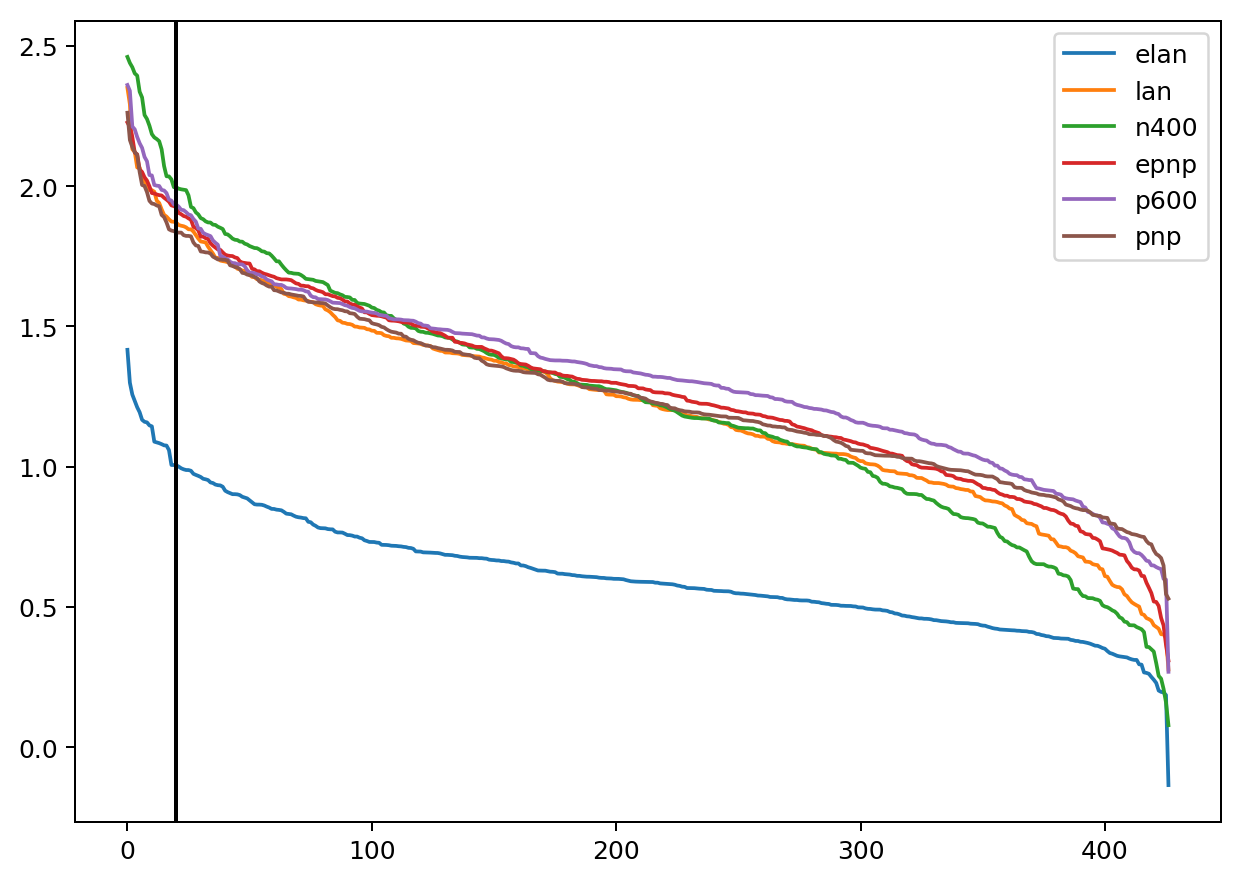

elan
Abby kneeled down to have another look in the tank that her mom had cleared so thoroughly, but Mr. Sticky was still nowhere to be found. [1.4165550470352173] sentential_co_ordination:1, object_relative_clause_non_restrictive:1
I then sat down on the floor and brushed away the hair that had accumulated on my shiny new Buster Brown shoes. [1.2993439435958862] non_local_verb_phrase_conjunction:1, source_relative_clause_non_restrictive:1
In response, the matron walked over to a little man sitting in an office chair that squeaked as it rolled around the floor and spoke to him. [1.257082462310791] non_local_verb_phrase_conjunction:1, source_relative_clause_non_restrictive:1, prepositional_phrase_attachment_ambiguity:1, gerund_modifier:1
Together they plunged into a mountain brook, which came foaming and dashing along, leaping over rocks and rushing down the hillside, until in the valley below they heard the strangest clattering noise. [1.2341972589492798] non_local_verb_phrase_conjuncti

In [53]:
max_erp_scored = score_sentences(sentence_outputs, 'natural_stories', max_erp_values, value_from='prediction')
render_subplot_artists(
    [SubplotArtist(width=7, height=5, render_fn=lambda ax: plot_scores(ax, max_erp_scored))], 
    dpi=180, is_tight_layout=True)
        
write_top_k('natural_stories', max_erp_scored, token_to_coding=token_key_to_coding)
coding_counts = top_k_coding_counts('natural_stories', token_key_to_coding, max_erp_scored, k=20)
for name in coding_counts:
    print(name)
    print(coding_counts[name])
    print('')
    print('')

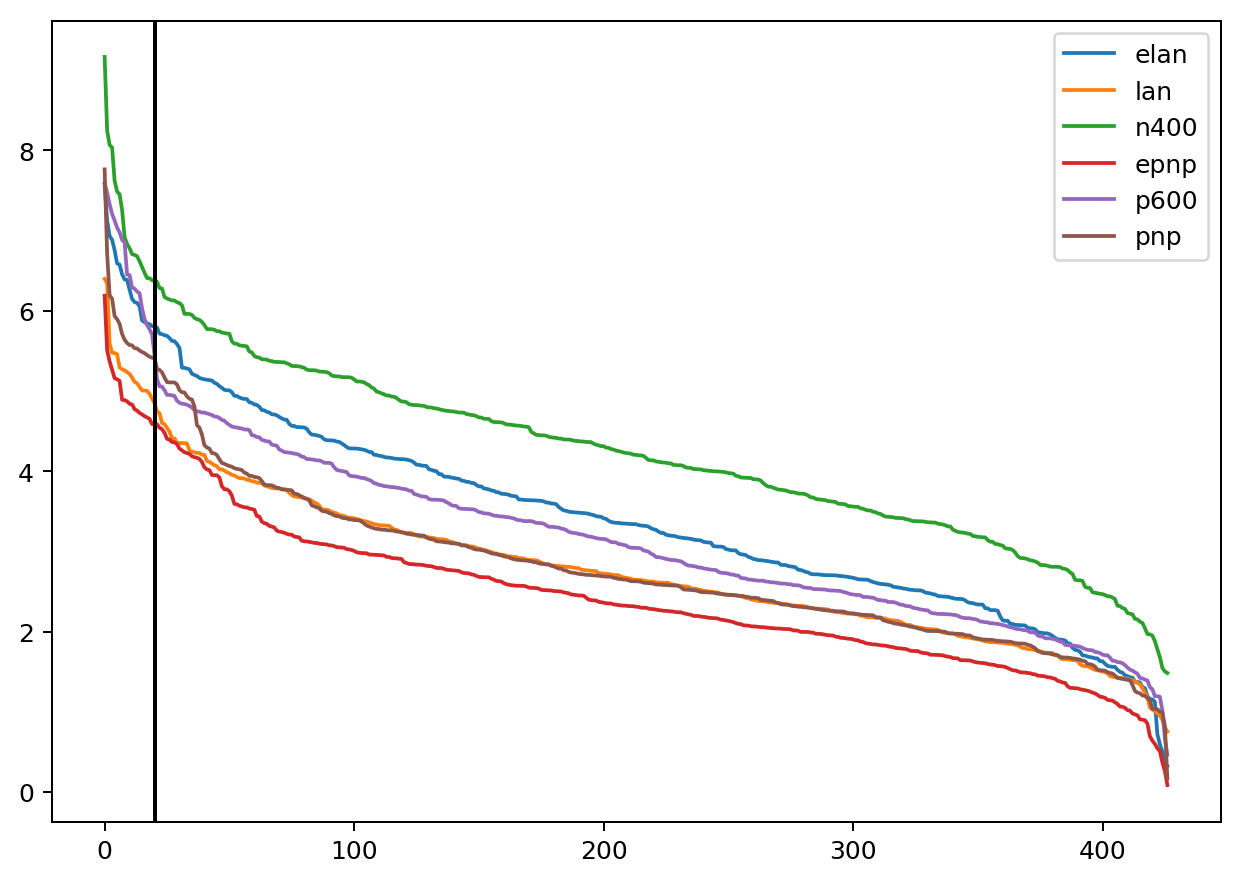

elan
That all mill owners were generally busy as beavers and quite pleased with themselves for being so successful and well off was known to the residents of Bradford, and if you were to go into the city to visit the stately City Hall, you would see there the Crest of the City of Bradford, which those same mill owners created to celebrate their achievements. [7.577284455299377] adjective_conjunction:2, object_relative_clause_non_restrictive:1, non_local_subject_verb:1, sentential_subject:1, if_then_construction:1, as_as_construction:1
Lucy did not know who it was that was sending her the messages, and she did not know how they had got her number, but whoever it was, he or she had slowly taken over Lucy's life. [7.12470243871212] sentential_co_ordination:1, complementizer_phrase_conjunctions:1, source_relative_clause_restrictive:1, object_relative_clause_restrictive:1, adverbial_relative_clause:1, free_relative_clause:3, it_cleft:1
The sun understood Aqua's request came from his heart, 

In [54]:
max_erp_scored = score_sentences(sentence_outputs, 'natural_stories', max_diff_erp, value_from='prediction')
render_subplot_artists(
    [SubplotArtist(width=7, height=5, render_fn=lambda ax: plot_scores(ax, max_erp_scored))], 
    dpi=180, is_tight_layout=True)
        
write_top_k('natural_stories', max_erp_scored, token_to_coding=token_key_to_coding)
coding_counts = top_k_coding_counts('natural_stories', token_key_to_coding, max_erp_scored, k=20)
for name in coding_counts:
    print(name)
    print(coding_counts[name])
    print('')
    print('')